# Convert DICOM to Nifti files 
to easily manipulate in 3D

(In future: can convert to HDF5 directly)

In [2]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
from collections import Counter
import matplotlib.pyplot as plt
import shutil
import pydicom
from util import convert_dicom_to_nifti, phase_from_label

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)

## Read in CSV data

In [5]:
# read in csv with phase info
csv_filepath = '/data/larson2/RCC_dl/metadata/anon_metadata_phase.csv'
savedf = pd.read_csv(csv_filepath)
print(len(savedf))

2407


## Convert noncon scans to nifti (from DICOM)

In [7]:
noncon = savedf[savedf['Phase Name'] == 'noncon'] #pull out exams with noncontrast phase
#print(len(noncon))
noncon = noncon[noncon['Stacked']==False] #remove the 5 stacked noncon cases (for now)
noncon.drop(['Unnamed: 0'], axis=1, inplace=True) #drop unnamed column
noncon.drop_duplicates(subset = ['Patient ID'], inplace=True) #remove duplicate noncon scans for each patient
#print(len(noncon))
noncon.reset_index(drop=True, inplace=True) #reset index after dropping duplicates
nonconlist = list(noncon.T.to_dict().values()) #convert df to list of dictionaries
#nonconlist.pop(212) # manually remove 9 cases that have errors during dicom2nifti
#nonconlist.pop(287) 
#nonconlist.pop(329) 
#nonconlist.pop(345) 
#nonconlist.pop(382)
#nonconlist.pop(391) 
#nonconlist.pop(482) 
#nonconlist.pop(708) 
#nonconlist.pop(745) 

print(len(nonconlist))

871
851
842


In [ ]:
dicom_base_dir = '/data/larson2/RCC_dl/1.all/'
nifti_base_dir = '/data/larson2/RCC_dl/data2022/'

for i, curr_id in enumerate(nonconlist):

    SerID = curr_id['SeriesInstanceUID']
    StuID = curr_id['StudyInstanceUID']
    PatID = curr_id['Patient ID']

    dicom_dir = os.path.join(dicom_base_dir, StuID, SerID)
    save_dir = os.path.join(nifti_base_dir, PatID)
    save_path = os.path.join(save_dir, 'noncon.nii.gz')

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    
    if os.path.isdir(dicom_dir):
        convert_dicom_to_nifti(dicom_dir, save_path, 0)
    else:
        print('No DICOM:', dicom_dir)
        continue

    print('Finished converting scan # ', i)

## Extract Phase Scans

In [16]:
dicom_base_dir = '/data/larson2/RCC_dl/1.all/'
nifti_base_dir = '/data/larson2/RCC_dl/data2022/'
pids = os.listdir(nifti_base_dir)
#print(pids)

phase_scans = savedf[(savedf['Phase Name'] == 'portven') | (savedf['Phase Name'] =='arterial') | (savedf['Phase Name'] =='delay')] #pull out exams with other phase
phase_scans = phase_scans[phase_scans['Patient ID'].isin(pids)] #remove exams that we dont have noncon scans for
phase_scans = phase_scans[phase_scans['Stacked']==False] #remove the 12 stacked cases (for now)
phase_scans.drop(['Unnamed: 0'], axis=1, inplace=True) #drop unnamed column
phase_scans.reset_index(drop=True, inplace=True) #reset index 
#print(phase_scans.shape)
phaselist = list(phase_scans.T.to_dict().values()) #convert df to list of dictionaries

#phaselist = phaselist[:2] #for debug
print(phaselist[:2])
print(len(phaselist))

[{'Stacked': False, 'Pixel Spacing': '[0.703125, 0.703125]', 'SeriesInstanceUID': '1.3.6.1.4.1.20319.279338780700959294712078064337761239497', 'Slice Thickness': 2.5, 'Patient ID': '6vAXtkl1b4', 'Prone': False, 'StudyInstanceUID': '1.3.6.1.4.1.20319.162208846280140663766132140430578984247', 'Series Number': 7, 'Phase Name': 'arterial'}, {'Stacked': False, 'Pixel Spacing': '[0.976562, 0.976562]', 'SeriesInstanceUID': '1.3.6.1.4.1.20319.319672205280929027470444425635901072798', 'Slice Thickness': 1.25, 'Patient ID': 'I5vsb46qUr', 'Prone': False, 'StudyInstanceUID': '1.3.6.1.4.1.20319.311609461682089371206875939120415204283', 'Series Number': 5, 'Phase Name': 'arterial'}]
1466


## Convert Phase Scans to Nifti

In [21]:
start = 1466 #index to start from

for i, curr_id in enumerate(phaselist[start:]):

    SerID = curr_id['SeriesInstanceUID']
    StuID = curr_id['StudyInstanceUID']
    PatID = curr_id['Patient ID']
    phasename = curr_id['Phase Name']

    dicom_dir = os.path.join(dicom_base_dir, StuID, SerID)
    save_dir = os.path.join(nifti_base_dir, PatID)
    save_name = phasename + '.nii.gz'
    save_path = os.path.join(save_dir, save_name)
    
    print('Patient ID:', PatID, 'Phase:', phasename, 'Study UID:', StuID)
    if os.path.isdir(dicom_dir):
        convert_dicom_to_nifti(dicom_dir, save_path, 0)
    else:
        print('No DICOM:', dicom_dir)
        print('Patient ID:', PatID)
        print('Phase:', phasename)
        continue

    print('Finished converting scan # ', i+start)

Remove scans that failed to convert to nii (167 scans-: 162 stacked, 5 other errors)

In [17]:
idx_to_remove = [11, 18, 22, 37, 50, 54, 64, 68, 69, 70, 72, 75, 79, 85, 92, 124, 130, 146, 151, 155, 169, 180, 184, 186, 191, 196, 198, 209, 220, 248, 254, 259, 289, 304, 307, 309, 322, 325, 331, 339,
343, 346, 348, 367, 374, 379, 392, 400, 404, 412, 417, 427, 444, 452, 483, 491, 494,
498, 508, 523, 548, 552, 556, 563, 567, 586, 636, 641, 652, 664, 669, 671, 700, 710, 714, 731, 734, 745, 753, 755, 763, 774, 786, 790, 792, 797, 802, 803, 813, 827, 834, 840, 842, 843, 845, 849, 877,
883, 893, 901, 912, 916, 924, 933, 945, 960, 965, 985, 989, 997, 1005, 1010, 1012, 1013, 1038, 1042, 1044, 1055, 1060, 1068, 1072, 1074, 1103, 1114, 1129, 1133, 1136, 1162, 1173, 1179, 1209, 1214, 1220,
1232, 1233, 1238, 1247, 1249, 1251, 1267, 1283, 1324, 1326, 1343, 1353, 1360, 1363, 1371, 1372, 1376, 1379, 1395, 1397, 1404, 1406, 1409, 1414, 1418, 1419, 1430, 1448, 1455, 1457, 1459, 1461, 1464, 1465]
phase_scans.drop(phase_scans.index[idx_to_remove], inplace=True)

In [22]:
print('Total number of phase scans saved as nifti:', phase_scans.shape[0])
print(Counter(phase_scans['Phase Name'])) # count number of scans for each contrast

# count number of unique patients we have phase scans for
phase_per_pid = phase_scans.drop_duplicates(subset = ['Patient ID'])
print('# of scans that have at least one phase image:', phase_per_pid.shape[0])

Total number of phase scans saved as nifti: 1299
Counter({'portven': 546, 'delay': 464, 'arterial': 289})
# of scans that have at least one phase image: 708


## Extract Phase Scans that will be easy to register to Noncon

First Remove exams where noncon and phase are in different orientation (i.e. only keep scans where noncon and phase are both supine)

In [ ]:
#noncon
#phase_scans

merged = noncon.merge(phase_scans, on='Patient ID', suffixes=('_noncon', '_phase'))
merged.drop_duplicates(subset = ['Patient ID'], inplace=True) #remove duplicate noncon scans for each patient
merged.reset_index(drop=True, inplace=True) #reset index after dropping duplicates
print(merged.head())
print(Counter(merged['Prone_noncon']))

Remove scans that may be more difficult to register becauase noncon and phase have different slice thickness

In [8]:
merged = merged[merged['Prone_noncon']==False]
print(merged.shape)
merged = merged[merged['Slice Thickness_noncon'] == merged['Slice Thickness_phase']]
print(merged.shape)

(625, 17)
(431, 17)


For now, just convert 431 easier cases to nii (i.e. cases where noncon and phase are both supine & have the same slice thickness)

In [ ]:
merged.reset_index(drop=True, inplace=True) #reset index after dropping duplicates
merged.drop(merged.filter(regex='_noncon').columns, axis=1, inplace=True) #drop all columms for noncon scna
#print(merged.head())
phaselist = list(merged.T.to_dict().values()) #convert df to list of dictionaries
#print(phaselist[:11])

#curr_id = phaselist[0]
#print(curr_id)

# Convert stacked cases to Nifti
Stacked = multiple volumes are stacked on top of each other in the DICOMS -- cant directly convert to Nifti, need to seperate into seperate DICOM folders first

Originally written by Ernesto Diaz
// Edited by Sule Sahin, 2023

In [ ]:
# for study uid, get series uid
study_uid = "1.3.6.1.4.1.20319.230696446481485152234109366972266119737"
pid = "OWdlqKybTr"
phase = "arterial"

excel_path = '/data/larson2/RCC_dl/metadata/anon_metadata_phase.csv'
df = pd.read_csv(excel_path)
#print(df.head())

phases = df[['Phase Name','SeriesInstanceUID']].loc[df["StudyInstanceUID"]==study_uid]
print(phases) #confirm phases match
num = df[(df.eq(study_uid).any(1)) & (df.apply(lambda row:phase in row.values,axis=1))]
series_uid = num.SeriesInstanceUID.values[0]
print(series_uid)

In [ ]:
#for each series uid number, seperate dicom folders by acquisition number in dicom metadata

save_path = "/data/larson2/RCC_dl/dicom_seperated/"
series_path = os.path.join("/data/larson2/RCC_dl/1.all/",study_uid,series_uid)

ann_path = '/data/larson2/RCC_dl/metadata/anon_metadata_annotations.csv'
df_ann = pd.read_csv(ann_path)
acq_phase = []
 
dirFiles = os.listdir(series_path)
dirFiles.sort() #This sorts in order numerically 
print(dirFiles)

#iterate through the folder 
for file in dirFiles:
 if file.endswith(".dcm"):
  ds = pydicom.dcmread(os.path.join(series_path,file))  # pull out acquisition number to seperate dicom files
  acquisition_num = ds.AcquisitionNumber
  labelname = df_ann["labelName"].loc[df_ann['SOPInstanceUID']==ds.SOPInstanceUID].values
  if labelname.size > 0:
    phasename = phase_from_label(str(labelname[0]))
    if phasename:
      acq_phase += [(acquisition_num, phasename)]
  save_folder = os.path.join(save_path,study_uid, series_uid, str(acquisition_num))
  if not os.path.exists(save_folder):
      os.makedirs(save_folder)
  shutil.copy(os.path.join(series_path,file), save_folder)

In [ ]:
print(acq_phase)

phasenames = [x[1] for x in acq_phase if x[0]==3]
phase_name = max(set(phasenames), key=phasenames.count)
print(phase_name)

acq_nums = list(set([x[0] for x in acq_phase]))
print(acq_nums)

In [ ]:
# determine phase name for seperated folders and rename folder to phase name and convert to nii
nii_dir = '/data/larson2/RCC_dl/data2022/'
acq_nums = list(set([x[0] for x in acq_phase]))
for num in acq_nums:
  phasenames = [x[1] for x in acq_phase if x[0]==num]
  phase_name = max(set(phasenames), key=phasenames.count)
  os.rename(os.path.join(save_path,study_uid, series_uid, str(num)), os.path.join(save_path,study_uid, series_uid, phase_name))
  save_to = os.path.join(nii_dir, pid, (phase_name+".nii.gz"))
  if not os.path.exists(save_to):
    convert_dicom_to_nifti(os.path.join(save_path,study_uid, series_uid, phase_name), save_to)
  else:
    print("file already exists:", save_to)

### Single image convert to nii (not looped) -- just for testing

In [ ]:
dicom_base_dir = '/data/larson2/RCC_dl/1.all/'
nifti_base_dir = '/data/larson2/RCC_dl/data2022/'

StuID = '1.3.6.1.4.1.20319.174365416403162751462812978713456918378' #StudyInstanceUID
SerID = '1.3.6.1.4.1.20319.269817141467407979152515624080249984670' #SeriesInstanceUID
PatID = 'DV4eLGjPkH' #Patient ID
phasename = 'portven'

dicom_dir = os.path.join(dicom_base_dir, StuID, SerID)
save_dir = os.path.join(nifti_base_dir, PatID)
save_name = phasename + '.nii.gz'
save_path = os.path.join(save_dir, save_name)

print('Patient ID:', PatID, 'Phase:', phasename, 'Study UID:', StuID)
if os.path.isdir(dicom_dir):
    convert_dicom_to_nifti(dicom_dir, save_path, 0)
else:
    print('No DICOM:', dicom_dir)
    print('Patient ID:', PatID)
    print('Phase:', phasename)
    exit()

print('Finished converting scan')

### Fix Nii Scans (flip + crop)

469


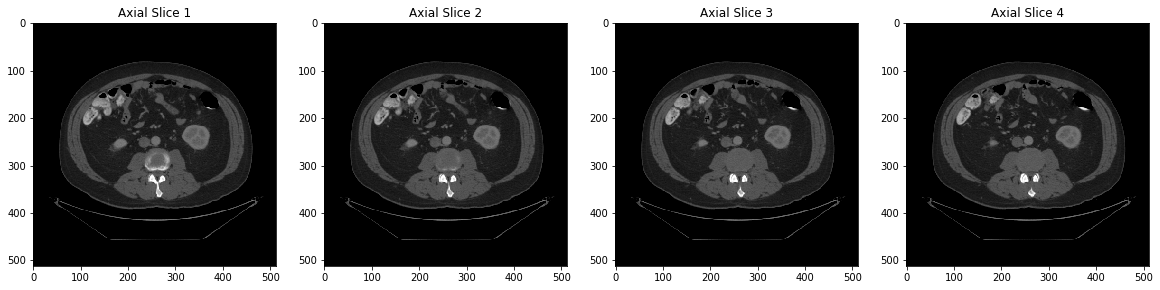

In [14]:
nifti_base_dir = '/data/larson2/RCC_dl/data2022/'
PatID = 'dTNNNPRqe0' #Patient ID
phasename = 'portven'
save_name = phasename + '.nii.gz'
nii_path = os.path.join(nifti_base_dir, PatID, save_name)
nii_image = nib.load(nii_path)
nii_data = nii_image.get_fdata()

ns = nii_data.shape[2]
print(ns)
slice_nums = [(ns//2)-1, (ns//2), (ns//2)+1, (ns//2)+2]
#slice_nums = [0, 1, 2, 3]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20,10), ncols=4) 

ax1.imshow(nii_data[:, :, slice_nums[0]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax1.set_title('Axial Slice 1')

ax2.imshow(nii_data[:, :, slice_nums[1]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax2.set_title('Axial Slice 2')

ax3.imshow(nii_data[:, :, slice_nums[2]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax3.set_title('Axial Slice 3')

ax4.imshow(nii_data[:, :, slice_nums[3]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax4.set_title('Axial Slice 4')

plt.show()


469


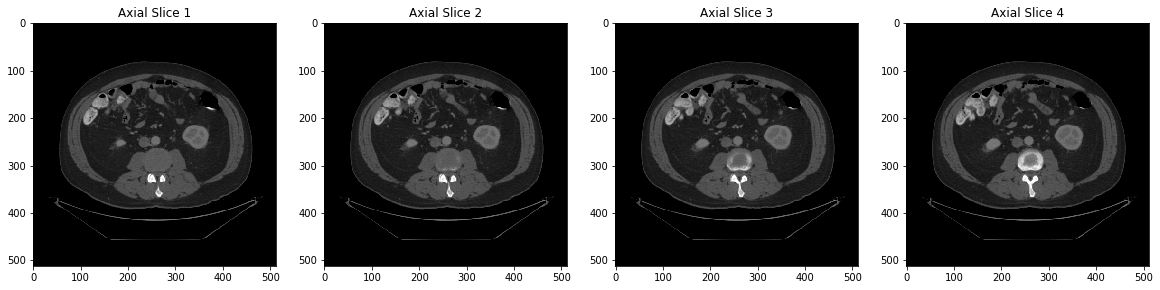

In [15]:

#nii_data_2 = np.flip(nii_data,2)
new_img = nib.Nifti1Image(nii_data, affine=nii_image.affine, header=nii_image.header) #save rotated image with previous header info
new_img = new_img.slicer[:, :, ::-1] #flip in z axis to match dicom data
#new_img = new_img.slicer[::-1, ::-1, :] #flip in x&y axis to match dicom data
#new_img = new_img.slicer[:, :, 3:69] 

nii_data = new_img.get_fdata()

ns = nii_data.shape[2]
print(ns)
slice_nums = [(ns//2)-1, (ns//2), (ns//2)+1, (ns//2)+2]
#slice_nums = [0, 1, 2, 3]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20,10), ncols=4) 

ax1.imshow(nii_data[:, :, slice_nums[0]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax1.set_title('Axial Slice 1')

ax2.imshow(nii_data[:, :, slice_nums[1]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax2.set_title('Axial Slice 2')

ax3.imshow(nii_data[:, :, slice_nums[2]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax3.set_title('Axial Slice 3')

ax4.imshow(nii_data[:, :, slice_nums[3]], cmap="Greys_r", interpolation='none', vmin=-200, vmax=800)
ax4.set_title('Axial Slice 4')

plt.show()

In [16]:
nib.save(new_img, nii_path)